## Text Analytics Group Assignment #2

Group members: Kemei Zhuo, Maggie Yu, Cherry Agarwal, Zhaoshun Su, Rulan Pan. 

In this assignment you are an analytics consultant to a (i) brand manager, (ii) product manager and (iii) advertising manager. Your job is to give advice/insights to these individuals based on the analysis of social media conversations. The detailed tasks are described below. We use cars as an example of a “high involvement” good (recall from class discussions that for high involvement goods, people use social media heavily for awareness building and research). 

1.    Develop a crawler/scraper using Selenium to fetch messages posted in Edmunds.com discussion forums. The crawler output should be a .csv file with the following columns: date, userid, and message (even though you will only use the messages in your analysis). Before you develop the crawler, carefully study one of the forums on Edmunds.com to understand the html as well as the threading structures. 

In [1]:
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys
import re
import pandas as pd
import os
from nltk.tokenize import word_tokenize
import numpy
from collections import defaultdict
from sklearn import manifold
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names

In [ ]:
# Import webdriver from selenium
from selenium import webdriver
chrome_path = r'C:/Users/zjfhz/Desktop/Text Analysis/chromedriver.exe'
driver = webdriver.Chrome(chrome_path)
driver.get("https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans")

In [ ]:
# start to read from page 2 to page 167
date_list = []
user_list = []
content_list = []
# get rid of repetitive website. 
for i in range(2, 167):
    python_button = driver.find_element_by_xpath("//a[@href='https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}']".format(i))
    python_button.click()
    soup_level2=BeautifulSoup(driver.page_source, 'lxml')
    date_list.extend([time[1:23] for time in str(soup_level2.find_all('time')).split('title=')[1:]])
    user = re.findall("profile/\w+", str(soup_level2.find_all('a', class_="Username")))
    user_list.extend([name[8:] for name in user])
    message = soup_level2.find_all('div', class_= re.compile("Message userContent"))
    message = [x.replace("<br/><br/>", " ").replace("</div>,", "").replace("\\n", "") for x in str(message).split('<div class="Message userContent">')[1:]]
    content_list.extend(message)
    

In [ ]:
# store the posts into a csv file called info
info = pd.concat([pd.DataFrame(date_list), pd.DataFrame(user_list), pd.DataFrame(content_list)], axis=1)
info.columns = ["date", "user", "post"]
#info.to_csv('info.csv')

In [2]:
dataset = pd.read_csv('info.csv')
# This spreadsheet has popular car models and brand; we use it to replace car models with brand name.
models = pd.read_csv('model_1.csv', header=None)
models.columns=['brand', 'model']

In [3]:
# data cleaning: There are <br/>2 and <br/> in post, and we did data cleaning as below.
for i in range(len(dataset['post'])):
    dataset['post'] = dataset['post'].map(lambda x: x.replace('<br/>2)', '').replace('<br/>', ' '))

    

In [4]:
# replace models with brands
for i in range(len(models)):
    model = models['model'][i].lower()
    brand = models['brand'][i].lower()
    dataset['post']=dataset['post'].map(lambda x: x.lower()).replace(to_replace=' '+model+' ', value=' '+brand+' ', regex=True)

In [5]:
# word_tokenize each post
token_text = dataset['post'].map(word_tokenize)
# take unique value of token_text for each post
unique_word = token_text.map(set)
# first five rows of unique_words
unique_word[:5]

0    {and, scheduled, they, just, fairly, money, is...
1    {all, help, just, alternatives, years, course,...
2    {secondly, all, show, being, domestic, kinks, ...
3    {and, q45, want, just, up, money, is, european...
4    {a, ago, based, of, couple, up, years, nationa...
Name: post, dtype: object

In [6]:
# The brand name we are focus on
brand_list = models['brand'].unique()
# and they are....
brand_list

array(['Acura', 'Alfa Romeo', 'Audi', 'Bentley', 'BMW', 'Buick',
       'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'Fiat', 'Ford',
       'Genesis', 'GMC', 'Honda', 'Hyundai', 'Infiniti', 'Jaguar', 'Jeep',
       'Kia', 'Land Rover', 'Lexus', 'Lincoln', 'Maserati', 'Mazda',
       'Mercedes-Benz', 'Mini', 'Mitsubishi', 'Nissan', 'Porsche', 'Ram',
       'Scion', 'Smart', 'Subaru', 'Toyota', 'Volkswagen', 'Volvo'],
      dtype=object)

In [7]:
# create a dictionary here 
brand_count = dict((brand, 0) for brand in brand_list)

In [8]:
# count the how often people mention each brand in posts
for i in range(len(unique_word)):
    for j in range(len(brand_list)):
        if brand_list[j].lower() in unique_word[i]:
            brand_count[brand_list[j]] = brand_count[brand_list[j]] + 1

### Task A:
    
Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations 
between the brands. You will have to write a script to do this task). Show the brands on a multi-
dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on 
the Internet). 

In [9]:
# the top 10 brands
top_10 = sorted(brand_count, key=brand_count.__getitem__, reverse=True)[:10]

for item in top_10:
    print item, brand_count[item]

BMW 1568
Acura 1067
Mercedes-Benz 476
Lexus 402
Audi 375
Honda 354
Infiniti 334
Mazda 277
Nissan 251
Cadillac 237


In [10]:
# create a default dictionary here
binary_count = defaultdict(int)

# loop over these top 10 brands and count the time when people mention them together
for i in range(len(top_10)):
    # select the brand
    brand1 = top_10[i]
    for j in range(i+1, len(top_10)):
        # select the second brand
        brand2 = top_10[j]
        #select each post
        for z in range(len(unique_word)):
                if brand1.lower() in unique_word[z] and brand2.lower() in unique_word[z] :
                    binary_count[(brand1, brand2)] = binary_count[(brand1, brand2)] + 1

In [14]:
# create a 10 * 10 matrix here
lift_ratio = numpy.zeros(shape=(10,10))
# create a 10 * 10 matrix here
dissimilarity = numpy.zeros(shape=(10,10))

N = len(dataset)
for i in range(len(top_10)):
    brand1 = top_10[i]
    for j in range(i+1, len(top_10)):
        brand2 = top_10[j]
        lift_ratio[i][j] = round(1.0*N*binary_count[(brand1, brand2)]/(brand_count[brand1]*brand_count[brand2]), 3)
        dissimilarity[i][j] = 1/lift_ratio[i][j]
        disbsimilarity[j][i] = 1/lift_ratio[i][j]
lift_table = pd.DataFrame(lift_ratio, columns=top_10, index=top_10)
lift_table

,BMW,Acura,Mercedes-Benz,Lexus,Audi,Honda,Infiniti,Mazda,Nissan,Cadillac
BMW,0.0,1.34,1.698,1.845,1.675,1.284,1.862,1.618,1.233,1.585
Acura,0.0,0.00,1.384,2.043,1.559,1.992,2.028,1.273,1.534,1.507
Mercedes-Benz,0.0,0.00,0.000,2.147,2.329,1.498,2.896,2.253,1.823,2.106
Lexus,0.0,0.00,0.000,0.000,2.561,1.426,4.129,2.178,1.864,2.910
Audi,0.0,0.00,0.000,0.000,0.000,1.454,3.162,2.049,1.788,2.729
Honda,0.0,0.00,0.000,0.000,0.000,0.000,1.340,2.474,4.457,1.593
Infiniti,0.0,0.00,0.000,0.000,0.000,0.000,0.000,1.873,3.484,2.814
Mazda,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,2.349,2.337
Nissan,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.082
Cadillac,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


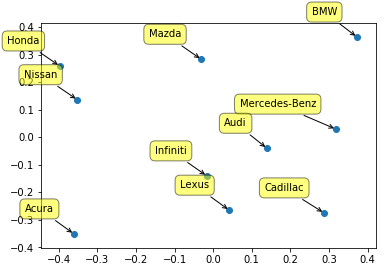

In [12]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(dissimilarity)
coords = results.embedding_
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(top_10, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()

### Task B:
 What insights can you offer brand managers from your analysis in Task A (choose two brands 
that you can offer the most interesting/useful insights for)? 


1.   	BMW. In this plot BMW seems to have a very unique image which is not often mentioned by other brands. The closest brand to BMW is Mercedes-Benz which is reasonable because they share a part of similar luxury market. The second closest brand is Mazda which is not that make sense but Mazda does advertise itself as “Japanese BMW”.
2.   	Acura. Again, Acura locates at the corner of the plot which means not often mentioned by other brand. However the closest two brands of Acura are Infiniti and Lexus which means Acura is more likely to be compared on Japan market.

### Task C:
 What are 5 most frequently mentioned attributes of cars in the discussions? Note that the 
same attribute may be described by different words – e.g., pick-up and acceleration may both refer 
to a more general attribute, “performance”. You have to make suitable replacements. Now pick the 
5 most frequently mentioned brands. Which attributes are most strongly associated with which of 
these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

We consider the attributes as follows: comfort, entertainment, safety, performance, service & care, cost, aesthetics, techonology, quality, size, purpose, reputation.

In [17]:
attribute = pd.read_csv('car.csv', sep='\t')

In [28]:
# the attributes we looked at are...
attribute_list = ['comfort', 'entertainment', 'safety', 'performance', 'servicecare', 'aesthetics', 'quality', 'size', 'purpose', 'reputation']

In [19]:
# replace descriptive words with attribute
for i in range(len(attribute)):
    Attr = attribute['Key'][i].lower()
    possible_word = attribute['possible_word'][i].lower()
    dataset['post_attr']=dataset['post'].map(lambda x: x.lower()).replace(to_replace=' '+possible_word+' ', value=' '+Attr+' ', regex=True)

In [20]:
token_text1 = dataset['post_attr'].map(word_tokenize)

In [21]:
attribute_count = dict((attribute, 0) for attribute in attribute_list)

In [22]:
# get unique words in each post
unique_word1 = token_text1.map(set)

In [23]:
# loop over both unique words in each post and the attribute list to find the frequency of these attributes
for i in range(len(unique_word1)):
    for j in range(len(attribute_list)):
        if attribute_list[j].lower() in unique_word1[i]:
            attribute_count[attribute_list[j]] = attribute_count[attribute_list[j]] + 1

In [24]:
attribute_count

{'aesthetics': 3,
 'comfort': 53,
 'entertainment': 7,
 'performance': 647,
 'purpose': 82,
 'quality': 160,
 'reputation': 31,
 'safety': 93,
 'servicecare': 0,
 'size': 133}

The 5 most frequently mentioned attributes of cars are:

In [29]:
# The top 5 attributes
top_5 = sorted(attribute_count, key=attribute_count.__getitem__, reverse=True)[:5]
for item in top_5:
    print item, attribute_count[item]

performance 647
quality 160
size 133
safety 93
purpose 82


Now let's find out which attributes are most strongly associated with which of these 5 brands.

In [30]:
# seperate the post by .,!?;:
token_sentence = dataset['post_attr'].map(lambda s: re.split(r'[.,!?;:]', s))

In [31]:
binary_count2 = defaultdict(int)

for i in range(0, 5):
    # select the top 5 brands here
    brand = top_10[i]
    
    for j in range(len(attribute_list)):
        # select the attribute here 
        attr = attribute_list[j]
        
        # select each post
        for z in range(len(token_sentence)):
            # inside each post, select each sentence
            for h in range(len(token_sentence[z])):
            # this is to check whether the brand name and the attribute appear in the same sentence.
                if brand.lower() in token_sentence[z][h] and attr.lower() in token_sentence[z][h] :
                    binary_count2[(brand, attr)] = binary_count2[(brand, attr)] + 1

We can see that 

Acura is strongly associated with performance, comfort, aesthetics, quality, and purpose;

Audi is strongly associated with performance, quality, aesthetics, comfort, and size;

BMW is strongly associated with performance, comfort, aesthetics, size, and quality;

Lexus is strongly associated with performance, comfort, aesthetics, quality, serivce care and size;

Mercedes-Benz is strongly associated with performance, comfort, size,  aesthetics, and quality

In [24]:
binary_count2

defaultdict(int,
            {('Acura', 'aesthetics'): 32,
             ('Acura', 'comfort'): 45,
             ('Acura', 'entertainment'): 3,
             ('Acura', 'performance'): 182,
             ('Acura', 'purpose'): 6,
             ('Acura', 'quality'): 14,
             ('Acura', 'reputation'): 1,
             ('Acura', 'safety'): 3,
             ('Acura', 'servicecare'): 1,
             ('Acura', 'size'): 23,
             ('Audi', 'aesthetics'): 13,
             ('Audi', 'comfort'): 10,
             ('Audi', 'entertainment'): 7,
             ('Audi', 'performance'): 56,
             ('Audi', 'purpose'): 1,
             ('Audi', 'quality'): 14,
             ('Audi', 'safety'): 2,
             ('Audi', 'servicecare'): 6,
             ('Audi', 'size'): 8,
             ('BMW', 'aesthetics'): 34,
             ('BMW', 'comfort'): 39,
             ('BMW', 'entertainment'): 3,
             ('BMW', 'performance'): 314,
             ('BMW', 'purpose'): 12,
             ('BMW', 'quality'): 

While BMW has claimed that they are the “ultimate driving machine”, is that how people feel on 
Edmunds? Show your analysis.   

The method used here is from https://pythonspot.com/python-sentiment-analysis/. 

First, I created a new csv file which contains positive words, negative words, and neutral words based on the posts. Positive words include fun, wonderful, fast, etc. Negative words include cramped, slow, boring, etc. Neutral words include bmw, represents, two, etc.

Then I trained the naivebayes classifier to predict the overall positivity of the posts which mentioned BMW. If the positive negative ratio is higher than 1, then people actually feel more positive towards this brand; if the positive negative ratio is lower than 1, then people feel more negative towards this brand. We can see from the positive / negative ratio below is 0.6646, which means that there are more negative comments than positive comments. Thus, people may not feel that BMW are the ultimate driving machines. 

In [32]:
# take out all the sentences which mentioned BMW
bmw_sentence = []
# loop over all the posts
for i in range(len(token_sentence)):
    # loop over all sentence in one post
    for j in range(len(token_sentence[i])):
        # for each descriptive word in attribute
        # if the sentence mentions bmw,
            temp = token_sentence[i][j].split(' ') 
            if 'bmw' in temp:
                bmw_sentence.append(token_sentence[i][j])

In [33]:
def word_feats(words):
    return dict([(word, True) for word in words])
pos_neg_words = pd.read_csv('pos_neg_words.csv') 
positive_vocab = list(pos_neg_words['positive_vocab'].dropna())
negative_vocab = list(pos_neg_words['negative_vocab'].dropna())
neutral_vocab = list(pos_neg_words['neutral_vocab'])
 
positive_features = [(word_feats(pos), 'pos') for pos in positive_vocab]
negative_features = [(word_feats(neg), 'neg') for neg in negative_vocab]
neutral_features = [(word_feats(neu), 'neu') for neu in neutral_vocab]
 
train_set = negative_features + positive_features + neutral_features
 
classifier = NaiveBayesClassifier.train(train_set) 


In [34]:
# Predict the positve / negative ratio
def pos_neg_ratio (sentences):
    pos_count = 0
    neg_count = 0
    for i in range(len(sentences)):
        neg = 0
        pos = 0
        sentence = sentences[i]
        sentence = sentence.lower()
        words = sentence.split(' ')
        for word in words:
            classResult = classifier.classify( word_feats(word))
            if classResult == 'neg':
                neg = neg + 1
            if classResult == 'pos':
                pos = pos + 1
        if str(float(pos)/len(words)) > str(float(neg)/len(words)):
            pos_count += 1
        else:
            neg_count += 1
    print 'positive to negative ratio is', pos_count*1.0/neg_count

In [35]:
pos_neg_ratio(bmw_sentence)

positive to negative ratio is 0.795634920635


Task D:
 What advice will you give to a (i) product manager, and (ii) marketing/advertising manager 
of these brands based on your analysis in Task C? For this assignment, you can assume the 
sentiment (e.g., that it is positive). 

(i) product manager

Based on the analysis above, we can provide advice about the most frequently attributes related to their products. Since all the attributes we listed are positive, we can safely assume that all the sentiments in our analysis are positive as well. Therefore, our analysis can help product managers to understand their customers better by their posts, what are the attributes customers really care about, what are the most frequently mentioned attributes and what are the least. For example, “entertainment” of BMW is relatively infrequently mentioned on Edmunds. Therefore, the product manager of BMW can focus more on the improving the entertainment system on BMW like let customer pair their cells phone easily, upgrade the in-car sound system, etc.

(ii)marketing/advertising manager

Marketing managers should focus on attributes which people related to their brands most frequently and advertise the attribute to impress more potential customers. If there are budget constraints, avoid spending money on advertising their attributes which people relate to their brands least frequently. For example for Lexus, the ratio of “comfort” relative posts over all its relative posts is higher than other brands’ ratios. Therefore, assuming all the sentiments are positive, Lexus is the brand which best satisfies customer’s requirement of “comfort”. Therefore, we recommend Lexus’s advertising manager to focus on advertising the “comfort” property of Lexus and therefore gain higher market share.

Task E:
 Which is the most 
aspirational
 brand in your data in terms of people actually wanting to buy 
or own? Describe your analysis. What are the business implications for this brand?

We assume that if people are saying more positive things about this brand, poeple actually want to buy or own this brand. We used the same method in evaluating whether BMW are the 'ultimate driving machine'. We can see below that infiniti and nissan has pos neg ratio higher than 1: Infiniti is 1.51, and nissan is 2.39. Thus, the most aspirational brand in my data is Nissan. 

As we can see from MDS Map, the Nissan locates very close to Honda, which means that they are competitors who are targeting the similar market. Notice that Honda has a pos neg ratio of 0.31. Thus, when people are comparing Nissan and Honda, they are saying more positive things about Nissan, and are more likely to shift to the Nissan. Thus, Nissan can target the customers who have a Honda and offer discounts or market to these customers to make them shift to Nissan. 

In [36]:
acura_sentence = []
benz_sentence = []
lexus_sentence = []
audi_sentence = []
honda_sentence = []
infiniti_sentence = []
mazda_sentence = []
nissan_sentence = []
cadillac_sentence = []
# loop over all the posts
for i in range(len(token_sentence)):
    # loop over all sentence in one post
    for j in range(len(token_sentence[i])):
        # for each descriptive word in attribute
        # if the sentence mentions bmw,
            temp = token_sentence[i][j].split(' ') 
            if 'mercedes-benz' in temp:
                benz_sentence.append(token_sentence[i][j])
            if 'acura' in temp:
                acura_sentence.append(token_sentence[i][j])
            if 'lexus' in temp:
                lexus_sentence.append(token_sentence[i][j])
            if 'audi' in temp:
                audi_sentence.append(token_sentence[i][j])
            if 'honda' in temp:
                honda_sentence.append(token_sentence[i][j])
            if 'infiniti' in temp:
                infiniti_sentence.append(token_sentence[i][j])
            if 'mazda' in temp:
                mazda_sentence.append(token_sentence[i][j])
            if 'nissan' in temp:
                nissan_sentence.append(token_sentence[i][j])
            if 'cadillac' in temp:
                cadillac_sentence.append(token_sentence[i][j])

In [37]:
print 'Accura'
pos_neg_ratio(acura_sentence)
print 'Mercedes-Benz'
pos_neg_ratio(benz_sentence)
print 'Lexus'
pos_neg_ratio(lexus_sentence)
print 'Audi'
pos_neg_ratio(audi_sentence)
print 'Honda'
pos_neg_ratio(honda_sentence)
print 'Infiniti'
pos_neg_ratio(infiniti_sentence)
print 'Mazda'
pos_neg_ratio(mazda_sentence)
print 'Nissan'
pos_neg_ratio(nissan_sentence)
print 'Cadillac'
pos_neg_ratio(cadillac_sentence)

Accura
positive to negative ratio is 0.38374717833
Mercedes-Benz
positive to negative ratio is 0.447580645161
Lexus
positive to negative ratio is 0.297539149888
Audi
positive to negative ratio is 0.305555555556
Honda
positive to negative ratio is 0.995689655172
Infiniti
positive to negative ratio is 1.50568181818
Mazda
positive to negative ratio is 0.813186813187
Nissan
positive to negative ratio is 2.39795918367
Cadillac
positive to negative ratio is 0.258823529412
